In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.set_printoptions(precision=3, suppress=True)

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?',
                      comment='\t', sep=' ', skipinitialspace=True)

In [3]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
dataset = dataset.dropna()

In [5]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1
dataset['Europe'] = (origin==2)*1
dataset['Japan'] = (origin == 3)*1
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(dataset.shape, train_dataset.shape, test_dataset.shape)

(392, 10) (314, 10) (78, 10)


In [7]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [8]:
train_x = train_dataset.copy()
train_y = train_x.pop('MPG')

test_x = test_dataset.copy()
test_y = test_x.pop('MPG')

In [9]:
def plot(feature, x=None, y=None):
    plt.figure(figsize=(10, 8))
    plt.scatter(train_x[feature], train_y, label='Data')
    if x is not None and y is not None:
        plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature)
    plt.ylabel('MPG')
    plt.legend()

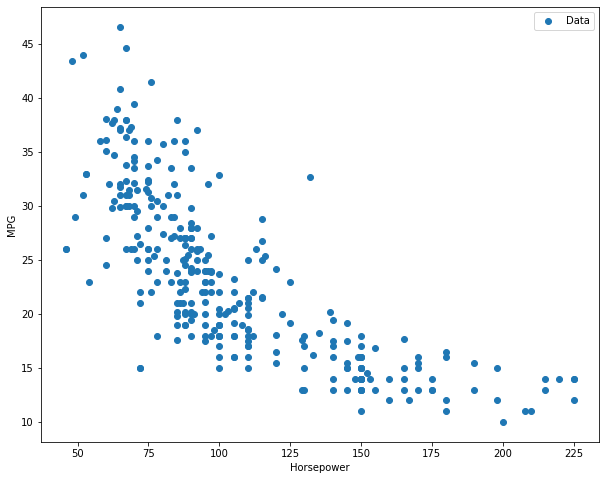

In [10]:
plot('Horsepower')

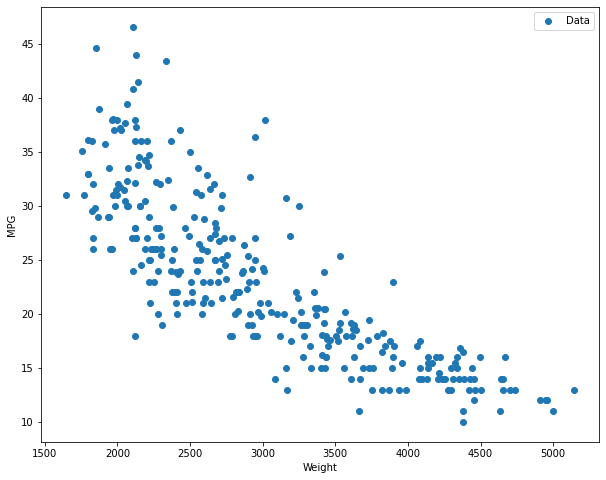

In [11]:
plot('Weight')

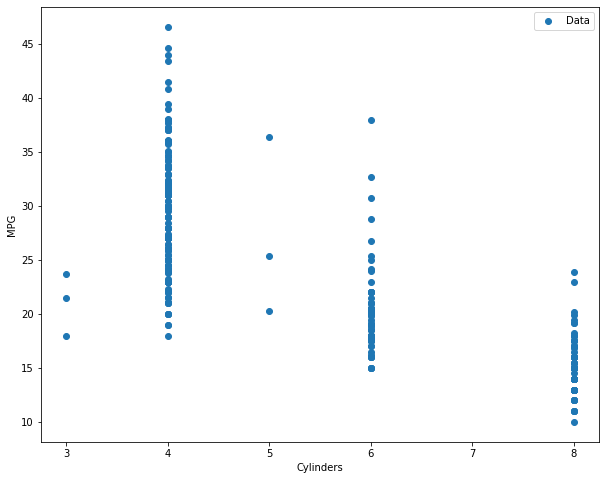

In [12]:
plot('Cylinders')

In [13]:
print(train_dataset.describe().transpose()[['mean', 'std']])

                     mean         std
MPG             23.310510    7.728652
Cylinders        5.477707    1.699788
Displacement   195.318471  104.331589
Horsepower     104.869427   38.096214
Weight        2990.251592  843.898596
Acceleration    15.559236    2.789230
Model Year      75.898089    3.675642
USA              0.624204    0.485101
Europe           0.178344    0.383413
Japan            0.197452    0.398712


## Normalization with Keras Preprocessing Normalization Class
Normalization works like:
$normalized input feature value = (input - mean / std)$

In [14]:
# Normalize
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_x))
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.624    0.178
     0.197]]


In [15]:
first = np.array(train_x[:1])
print('Raw example: ', first)
print('Normalized example: ', normalizer(first).numpy())

Raw example:  [[   4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]
Normalized example:  [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517  0.776 -0.466 -0.496]]


## Regression
$y = mx + b$

In [16]:
feature = 'Weight'
single_feature = np.array(train_x[feature])
print(single_feature.shape, train_x.shape)

(314,) (314, 9)


In [17]:
single_feature_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
single_feature_normalizer.adapt(single_feature)

In [18]:
single_feature_model = keras.models.Sequential([
    single_feature_normalizer,
    layers.Dense(units=1) # Linear Model
])

single_feature_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


### Loss Functions
Mean Squared Error:
Mean Absolute Error:

In [19]:
loss = keras.losses.MeanAbsoluteError()
optimizer = keras.optimizers.Adam(learning_rate=0.1)

single_feature_model.compile(optimizer, loss)

In [20]:
history = single_feature_model.fit(train_x[feature], train_y, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
8/8 [==============================] - 0s 17ms/step - loss: 22.8903 - val_loss: 22.9151
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 22.0667 - val_loss: 22.1140
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 21.2670 - val_loss: 21.3141
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 20.4717 - val_loss: 20.5128
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 19.6726 - val_loss: 19.7155
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 18.8664 - val_loss: 18.9154
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 18.0667 - val_loss: 18.1149
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 17.2672 - val_loss: 17.3158
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 16.4668 - val_loss: 16.5166
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 15.6660 - val_loss: 15.7165
Epoch 11

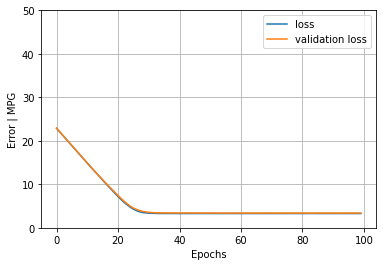

In [21]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylim([0, 50])
    plt.xlabel('Epochs')
    plt.ylabel('Error | MPG')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [22]:
single_feature_model.evaluate(test_x[feature], test_y, verbose=1)

3/3 [==============================] - 0s 2ms/step - loss: 3.1082


3.1082496643066406

7/7 [==============================] - 0s 1ms/step


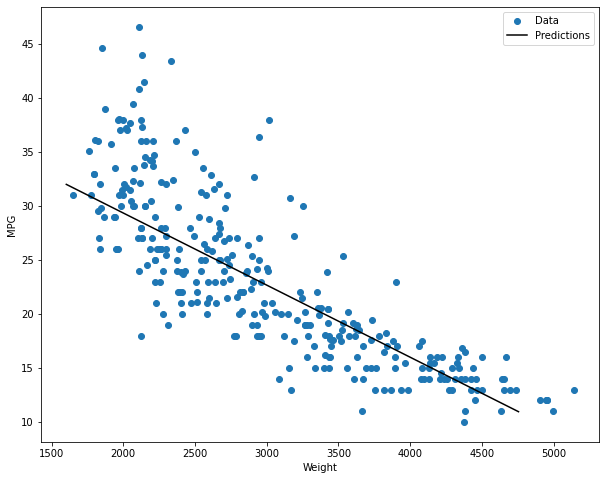

In [23]:
range_min = np.min(test_x[feature]) - 10
range_max = np.max(test_x[feature]) + 10
x = tf.linspace(range_min, range_max, 200)
y = single_feature_model.predict(x)

plot(feature, x, y)

In [24]:
dnn_model = keras.Sequential([
    single_feature_normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

loss = keras.losses.MeanAbsoluteError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

dnn_model.compile(optimizer, loss)

dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 64)                128       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [25]:
history = dnn_model.fit(train_x[feature], train_y, validation_split=0.2, verbose=1, epochs=100)

Epoch 1/100
8/8 [==============================] - 0s 16ms/step - loss: 23.0910 - val_loss: 23.4585
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 22.8226 - val_loss: 23.1651
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 22.5157 - val_loss: 22.8272
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 22.1489 - val_loss: 22.3941
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 21.6749 - val_loss: 21.8331
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 21.0684 - val_loss: 21.1050
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 20.2738 - val_loss: 20.1696
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 19.2477 - val_loss: 18.9970
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 17.9838 - val_loss: 17.5362
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 16.4020 - val_loss: 15.8433
Epoch 11

In [26]:
dnn_model.evaluate(test_x[feature], test_y, verbose=1)

3/3 [==============================] - 0s 2ms/step - loss: 2.7518


2.751774787902832

7/7 [==============================] - 0s 1ms/step


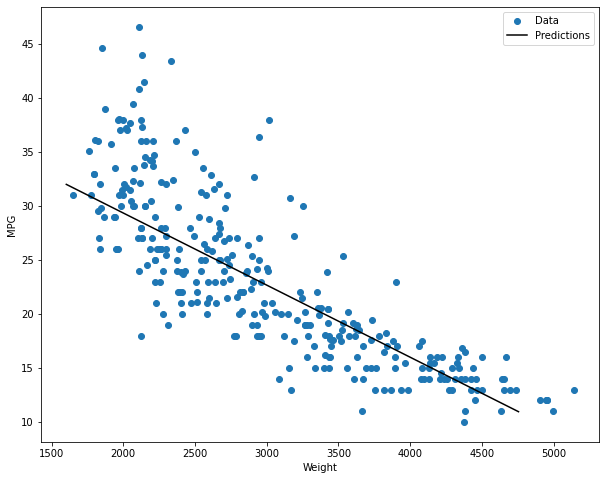

In [27]:
x = tf.linspace(range_min, range_max, 200)
y = single_feature_model.predict(x)

plot(feature, x, y)

In [28]:
linear_model = keras.Sequential([
    normalizer,
    layers.Dense(1)
])

loss = keras.losses.MeanAbsoluteError()
optimizer = keras.optimizers.Adam(learning_rate=0.1)

linear_model.compile(optimizer, loss)

linear_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


In [29]:
history = linear_model.fit(train_x, train_y, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
8/8 [==============================] - 0s 16ms/step - loss: 22.9405 - val_loss: 22.9865
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 22.0587 - val_loss: 22.2663
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 21.2476 - val_loss: 21.5680
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 20.4104 - val_loss: 20.8296
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 19.5951 - val_loss: 20.1234
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 18.7660 - val_loss: 19.3886
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 17.9454 - val_loss: 18.6585
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 17.1352 - val_loss: 17.9379
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 16.3358 - val_loss: 17.2309
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 15.5156 - val_loss: 16.4915
Epoch 11

In [30]:
linear_model.evaluate(test_x, test_y, verbose=1)

3/3 [==============================] - 0s 2ms/step - loss: 2.4546


2.454596519470215

In [31]:
dnn_model = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

loss = keras.losses.MeanAbsoluteError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

dnn_model.compile(optimizer, loss)

dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [32]:
history = dnn_model.fit(train_x, train_y, validation_split=0.2, verbose=1, epochs=100)

Epoch 1/100
8/8 [==============================] - 0s 16ms/step - loss: 23.0371 - val_loss: 23.1983
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 22.4519 - val_loss: 22.5227
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 21.7624 - val_loss: 21.6378
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 20.8269 - val_loss: 20.4598
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 19.5686 - val_loss: 18.8968
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 17.9474 - val_loss: 16.8700
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 15.9172 - val_loss: 14.7782
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 13.8961 - val_loss: 12.8501
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 11.7510 - val_loss: 10.5292
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 9.3512 - val_loss: 7.6858
Epoch 11/1

In [33]:
dnn_model.evaluate(test_x, test_y, verbose=1)

3/3 [==============================] - 0s 2ms/step - loss: 1.6481


1.6480777263641357